# implementation of ID3


In [73]:
import pandas as pd
import numpy  as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
def totalEntropy(train_data, label, class_list):
    total_row = train_data.shape[0] #the total size of the dataset
    total_entr = 0
    
    for c in class_list: #for each class in the label
        total_class_count = train_data[train_data[label] == c].shape[0] #number of the class
        total_class_entr = - (total_class_count/total_row)*np.log2(total_class_count/total_row) #entropy of the class
        total_entr += total_class_entr #adding the class entropy to the total entropy of the dataset
    
    return total_entr

In [75]:
def feature_entropy(feature_value_data, label, class_list):
    class_count = feature_value_data.shape[0]
    entropy = 0
    
    for c in class_list:
        label_class_count = feature_value_data[feature_value_data[label] == c].shape[0] #row count of class c 
        entropy_class = 0
        if label_class_count != 0:
            probability_class = label_class_count/class_count #probability of the class
            entropy_class = - probability_class * np.log2(probability_class)  #entropy
        entropy += entropy_class
    return entropy
  

In [76]:
def informationgain(feature_name, train_data, label, class_list):
    feature_value_list = train_data[feature_name].unique() #unqiue values of the feature
    total_row = train_data.shape[0]
    feature_info = 0.0
    
    for feature_value in feature_value_list:
        feature_value_data = train_data[train_data[feature_name] == feature_value] #filtering rows with that feature_value
        feature_value_count = feature_value_data.shape[0]
        feature_value_entropy = feature_entropy(feature_value_data, label, class_list) #calculcating entropy for the feature value
        feature_value_probability = feature_value_count/total_row
        feature_info += feature_value_probability * feature_value_entropy #calculating information of the feature value
        
    return totalEntropy(train_data, label, class_list) - feature_info #calculating information gain by subtracting


In [77]:
def find_most_informative_feature(train_data, label, class_list,size_ID3):
    feature_list = train_data.columns.drop(label) #finding the feature names in the dataset
    max_info_gain = -1
    max_info_feature = None
    
    for feature in feature_list:  #for each feature in the dataset
        feature_info_gain = informationgain(feature, train_data, label, class_list)
        if max_info_gain < feature_info_gain: #selecting feature name with highest information gain
            max_info_gain = feature_info_gain
            max_info_feature = feature
    size_ID3.append(max_info_feature)        
    return max_info_feature,size_ID3

In [78]:
def generate_sub_tree(feature_name, train_data,train_data_column, label, class_list):
    feature_value_count_dict = train_data[feature_name].value_counts(sort=False) #dictionary of the count of unqiue feature value
    tree = {} #sub tree or node
    maxvote=[-1,-2]
    i=0
    fe = train_data_column.columns #finding the feature names in the dataset
    for feature_value, count in feature_value_count_dict.iteritems():
        feature_value_data = train_data[train_data[feature_name] == feature_value] #dataset with only feature_name = feature_value
        assigned_to_node = False #flag for tracking feature_value is pure class or not
        for c in class_list: #for each class
            class_count = feature_value_data[feature_value_data[label] == c].shape[0] #count of class c
            if class_count == count: #count of feature_value = count of class (pure class)
                tree[feature_value] = c #adding node to the tree
                train_data = train_data[train_data[feature_name] != feature_value] #removing rows with feature_value
                assigned_to_node = True
            elif (len(list(train_data_column.columns))==2) & (class_count!=0):
    
                maxvote[i]=class_count
                i=i+1
            else:
                pass
        
        if  (maxvote[0]>0) & (maxvote[1]>0):
            
            
            assigned_to_node = True
            if(maxvote[0]>maxvote[1]):
                tree[feature_value] = class_list[0]
                train_data = train_data[train_data[feature_name] != feature_value]
            elif maxvote[1]>maxvote[0]:  
                tree[feature_value] = class_list[1]
                train_data = train_data[train_data[feature_name] != feature_value]
            else:
               
                tree[feature_value] = class_list[0]
                train_data = train_data[train_data[feature_name] != feature_value]
        maxvote=[-1,-2]
        i=0        
        if not assigned_to_node: #not pure class
            tree[feature_value] = "?" #should extend the node, so the branch is marked with ?
            
    return tree, train_data

In [79]:
def make_tree(root, prev_feature_value, train_data,train_data_column, label, class_list,size_ID3):
    if train_data.shape[0] != 0: #if dataset becomes enpty after updating
        max_info_feature,size_ID3 = find_most_informative_feature(train_data_column,label, class_list,size_ID3) #most informative feature
        tree, train_data = generate_sub_tree(max_info_feature, train_data,train_data_column, label, class_list) #getting tree node and updated dataset
        next_root = None
        if prev_feature_value != None: #add to intermediate node of the tree
            root[prev_feature_value] = dict()
            root[prev_feature_value][max_info_feature] = tree
            next_root = root[prev_feature_value][max_info_feature]
        else: #add to root of the tree
            root[max_info_feature] = tree
            next_root = root[max_info_feature]
        for node, branch in list(next_root.items()): #iterating the tree node
            if branch == "?": #if it is expandable
                feature_value_data = train_data[train_data[max_info_feature] == node] #using the updated dataset
                a=train_data_column.drop(columns=max_info_feature).copy()
                make_tree(next_root, node, feature_value_data,a,label, class_list,size_ID3) #recursive call with updated dataset
    else:
        return

In [80]:
def id3(train_data_m, label,size_ID3):
    train_data = train_data_m.copy() #getting a copy of the dataset
    tree = {} #tree which will be updated
    class_list = train_data[label].unique() #getting unqiue classes of the label
    make_tree(tree, None, train_data_m, train_data_m,label, class_list,size_ID3) #start calling recursion
    return tree,size_ID3

In [81]:
def predict(tree, instance):
    if not isinstance(tree, dict): #if it is leaf node
        return tree #return the value
    else:
        root_node = next(iter(tree)) #getting first key/feature name of the dictionary
        feature_value = instance[root_node] #value of the feature
        if feature_value in tree[root_node]: #checking the feature value in current tree node
            return predict(tree[root_node][feature_value], instance) #goto next feature
        else:
            return None

In [82]:
def evaluate(tree, test_data_m, label):
    correct_preditct = 0
    wrong_preditct = 0
    for index, row in test_data_m.iterrows(): #for each row in the dataset
        result = predict(tree, test_data_m.iloc[index]) #predict the row
        if result == test_data_m[label].iloc[index]: #predicted value and expected value is same or not
            correct_preditct += 1 #increase correct count
        else:
            wrong_preditct += 1 #increase incorrect count
    accuracy = correct_preditct / (correct_preditct + wrong_preditct) #calculating accuracy
    return accuracy


In [83]:
adult_train=pd.read_csv(r'C:\Users\PLUS\Desktop\Linkpy\adult.train.10k.text')
adult_test=pd.read_csv(r'C:\Users\PLUS\Desktop\Linkpy\adult.test.10k.text')


In [84]:
def change(x):
    if x=='<=50K':
        x='yes' 
    else:
        x='No'
    return x

In [85]:
for i in range(len(adult_test.columns)):
    adult_test.rename(columns={adult_test.columns[i]:adult_train.columns[i]},inplace=True)

In [86]:
adult_train['<=50K']=adult_train['<=50K'].apply(change)
adult_test['<=50K']=adult_test['<=50K'].apply(change)



# solve:1)a

In [87]:
 tree_45,s=id3(adult_train.sample(frac=0.45),'<=50K',[])

In [88]:
data_test_on_train=adult_test.iloc[:,1:]

In [89]:
res=[]
for i in range(len(data_test_on_train.index)):
    
    result=predict(tree_45, adult_test.iloc[i])
    res.append(result)    
data_test_on_train['<=50K']=res    

In [90]:
data_test_on_train

,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
0,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States,yes
1,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States,yes
2,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States,yes
3,Private,10th,Never-married,Other-service,Not-in-family,White,Male,United-States,yes
4,Self-emp-not-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,No
...,...,...,...,...,...,...,...,...,...
9994,Self-emp-not-inc,Prof-school,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,yes
9995,Private,HS-grad,Never-married,Tech-support,Unmarried,White,Female,United-States,yes
9996,State-gov,HS-grad,Divorced,Protective-serv,Not-in-family,White,Male,United-States,None
9997,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,yes


In [91]:
adult_test

,<=50K,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States
0,yes,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,United-States
1,No,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,United-States
2,No,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,United-States
3,yes,Private,10th,Never-married,Other-service,Not-in-family,White,Male,United-States
4,No,Self-emp-not-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States
...,...,...,...,...,...,...,...,...,...
9994,yes,Self-emp-not-inc,Prof-school,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
9995,yes,Private,HS-grad,Never-married,Tech-support,Unmarried,White,Female,United-States
9996,yes,State-gov,HS-grad,Divorced,Protective-serv,Not-in-family,White,Male,United-States
9997,yes,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States


In [36]:
ac_test=[]
for i in range(3):
    t,s=id3(adult_train.sample(frac=0.45),'<=50K',[])
    print('size 0.45 is %i:'%(len(s)))
    accuracy_train=evaluate(t,adult_train,'<=50K')
    print('accuracy_train:',accuracy_train)
    accuracy_test=evaluate(t,adult_test,'<=50K')
    print('accuracy_test:',accuracy_test)
    ac_test.append(accuracy_test)

size 0.45 is 821:
accuracy_train: 0.8024802480248024
accuracy_test: 0.7358735873587359
size 0.45 is 862:
accuracy_train: 0.7977797779777978
accuracy_test: 0.7212721272127213
size 0.45 is 792:
accuracy_train: 0.7984798479847984
accuracy_test: 0.7309730973097309


In [37]:
mean_accuracy_test_45=sum(ac_test)/3
print(mean_accuracy_test_45)


0.7293729372937294


# solve:1)b

In [ ]:
 t,s=id3(adult_train.sample(frac=0.45),'<=50K')

In [42]:
frac_of_adult_train=[0.55,0.65,0.75]
print('size of %s is %i:'%(frac_of_adult_train[0],len(frac_of_adult_train)))


size of 0.55 is 3:


In [43]:
for i in range(3):
    t,s=id3(adult_train.sample(frac=frac_of_adult_train[i]),'<=50K',[])
    print('size of %s is %i:'%(frac_of_adult_train[i],len(s)))
    accuracy_train=evaluate(t,adult_train,'<=50K')
    print('accuracy_train of %s is %f:'%(frac_of_adult_train[i],accuracy_train))
    accuracy_test=evaluate(t,adult_test,'<=50K')
    print('accuracy_test of %s is %f:'%(frac_of_adult_train[i],accuracy_test))
    #ac_test.append(accuracy_test)

size of 0.55 is 893:
accuracy_train of 0.55 is 0.815182:
accuracy_test of 0.55 is 0.731573:
size of 0.65 is 1042:
accuracy_train of 0.65 is 0.829283:
accuracy_test of 0.65 is 0.736674:
size of 0.75 is 1174:
accuracy_train of 0.75 is 0.846085:
accuracy_test of 0.75 is 0.739674:


In [17]:
tree_total,size=id3(adult_train,'<=50K',[])
print('size of total is %i:'%(len(size)))
accuracy_train=evaluate(tree_total,adult_train,'<=50K')
print('accuracy_train of total is %f:'%(accuracy_train))
accuracy_test=evaluate(tree_total,adult_test,'<=50K')
print('accuracy_test of total is %f:'%(accuracy_test))

size of total is 1424:
accuracy_train of total is 0.875388:
accuracy_test of total is 0.748275:


In [44]:
mean_of_accuracy_train=[]
for i in range(3):
    for j in range(3):
        t,s=id3(adult_train.sample(frac=frac_of_adult_train[i]),'<=50K',[])
        print('size of %s is %i:'%(frac_of_adult_train[i],len(s)))
        accuracy_train=evaluate(t,adult_train,'<=50K')      
        print('accuracy_train of %s is %f:'%(frac_of_adult_train[i],accuracy_train))
        accuracy_test=evaluate(t,adult_test,'<=50K')
        mean_of_accuracy_train.append(accuracy_test)      
        print('accuracy_test of %s is %f:'%(frac_of_adult_train[i],accuracy_test))
    print('mean of test by %s of train is %f'%(frac_of_adult_train[i],sum(mean_of_accuracy_train)/3))
    mean_of_accuracy_train=[]          


size of 0.55 is 945:
accuracy_train of 0.55 is 0.813081:
accuracy_test of 0.55 is 0.729573:
size of 0.55 is 992:
accuracy_train of 0.55 is 0.815782:
accuracy_test of 0.55 is 0.728973:
size of 0.55 is 989:
accuracy_train of 0.55 is 0.820582:
accuracy_test of 0.55 is 0.734573:
mean of test by 0.55 of train is 0.731040
size of 0.65 is 1068:
accuracy_train of 0.65 is 0.829783:
accuracy_test of 0.65 is 0.730073:
size of 0.65 is 1037:
accuracy_train of 0.65 is 0.828783:
accuracy_test of 0.65 is 0.740474:
size of 0.65 is 1070:
accuracy_train of 0.65 is 0.832883:
accuracy_test of 0.65 is 0.737374:
mean of test by 0.65 of train is 0.735974
size of 0.75 is 1136:
accuracy_train of 0.75 is 0.846885:
accuracy_test of 0.75 is 0.739174:
size of 0.75 is 1157:
accuracy_train of 0.75 is 0.845985:
accuracy_test of 0.75 is 0.742474:
size of 0.75 is 1201:
accuracy_train of 0.75 is 0.845685:
accuracy_test of 0.75 is 0.740274:
mean of test by 0.75 of train is 0.740641


In [47]:
frac_of_train_adult_train=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

In [48]:
accuracy_train_labale=[]
accuracy_test_labale=[]
size_node=[]
for i in range(len(frac_of_train_adult_train)):
    t,s=id3(adult_train.sample(frac=frac_of_train_adult_train[i]),'<=50K',[])
    size_node.append(s)
    print('size of %s is %i:'%(frac_of_train_adult_train[i],len(s)))
    accuracy_train=evaluate(t,adult_train,'<=50K')
    accuracy_train_labale.append(accuracy_train)
    print('accuracy_train of %s is %f:'%(frac_of_train_adult_train[i],accuracy_train))
    accuracy_test=evaluate(t,adult_test,'<=50K')
    accuracy_test_labale.append(accuracy_test)
    print('accuracy_test of %s is %f:'%(frac_of_train_adult_train[i],accuracy_test))

size of 0.1 is 235:
accuracy_train of 0.1 is 0.692369:
accuracy_test of 0.1 is 0.661366:
size of 0.2 is 478:
accuracy_train of 0.2 is 0.742774:
accuracy_test of 0.2 is 0.696170:
size of 0.3 is 573:
accuracy_train of 0.3 is 0.759676:
accuracy_test of 0.3 is 0.705471:
size of 0.4 is 725:
accuracy_train of 0.4 is 0.787979:
accuracy_test of 0.4 is 0.717672:
size of 0.5 is 875:
accuracy_train of 0.5 is 0.802980:
accuracy_test of 0.5 is 0.725373:
size of 0.6 is 957:
accuracy_train of 0.6 is 0.827883:
accuracy_test of 0.6 is 0.742274:
size of 0.7 is 1108:
accuracy_train of 0.7 is 0.839784:
accuracy_test of 0.7 is 0.742174:
size of 0.8 is 1215:
accuracy_train of 0.8 is 0.849985:
accuracy_test of 0.8 is 0.741674:
size of 0.9 is 1347:
accuracy_train of 0.9 is 0.862586:
accuracy_test of 0.9 is 0.737074:
size of 1 is 1424:
accuracy_train of 1 is 0.875388:
accuracy_test of 1 is 0.748275:


In [58]:
size=[]
for i in range(len(size_node)):
    size.append(len(size_node[i]))
  

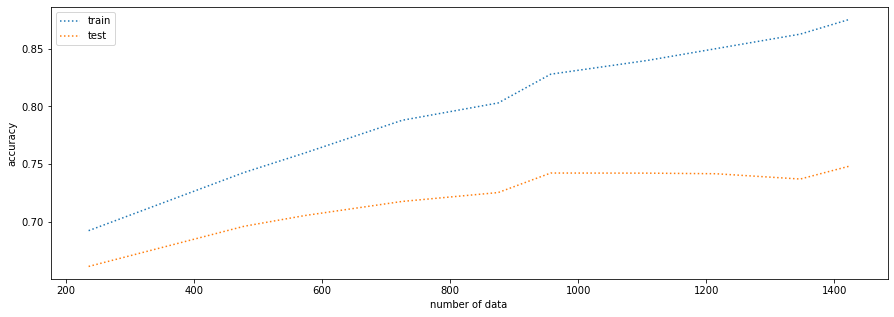

In [70]:
plt.figure(figsize=(15, 5))
plt.plot(size, accuracy_train_labale, label = "train",linestyle = 'dotted')
plt.plot(size, accuracy_test_labale, label = "test",linestyle = 'dotted')
plt.xlabel('number of data')
plt.ylabel('accuracy')
plt.legend()
plt.show()